# Pull out the User Explorer report with Python

We can get Client Ids from a Universal Analytics, to know how many sessions a user had as well as times, dates, pages visited, goals completed, events triggered as well as the channel they came in.

But to visualise that or look at it in a spreadsheet? that is Not possible through the Universal Analytics.

Thus we have to use the Google Analytics Reporting API v4.

https://medium.com/@alrowe/how-to-pull-out-the-user-explorer-report-with-python-useractivity-search-369bc5052093

### Client Ids
The code from the quickstart guide:
https://developers.google.com/analytics/resources/samples/service-py-v4.txt

### import Libraries

In [88]:
from apiclient.discovery import build
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
from pandas import json_normalize

from oauth2client.service_account import ServiceAccountCredentials
import csv
import json 

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
# credentials

SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
KEY_FILE_LOCATION = 'xxxxxx.json'
VIEW_ID = 'xxxxxx' #grab this from google analytics view property

In [129]:
"""Hello Analytics Reporting API V4."""

"""Initializes an Analytics Reporting API V4 service object.
Returns:
  An authorized Analytics Reporting API V4 service object.
"""

def initialize_analyticsreporting():
    credentials = ServiceAccountCredentials.from_json_keyfile_name(KEY_FILE_LOCATION, SCOPES)
    # Build the service object.
    analytics = build('analyticsreporting', 'v4',credentials=credentials)
    return analytics


"""Queries the Analytics Reporting API V4.
Args:
   analytics: An authorized Analytics Reporting API V4 service object.
Returns:
   The Analytics Reporting API V4 response.
"""

def get_report(analytics):
    return analytics.reports().batchGet(
       body = {
          "reportRequests": [
              {
                'viewId': VIEW_ID,
                'pageSize': 100000,
                'includeEmptyRows': True,
                'samplingLevel': 'LARGE',
                'dateRanges': [
                   {
                       'startDate': '2023-01-01',
                       'endDate': 'yesterday'
                   }
                ],
                'metrics': [
                   {
                      'expression': 'ga:sessions'
                   }
                ],
               # 'filtersExpression': 'ga:sessions>2',
                'dimensions': [
                   {
                      'name': "ga:clientId"
                   }
                ]
            }
         ]
      }
   ).execute()


def parse_data(response):
    reports = response['reports'][0]
    columnHeader = reports['columnHeader']['dimensions']
    metricHeader = reports['columnHeader']['metricHeader']['metricHeaderEntries']
    columns = columnHeader
    for metric in metricHeader:
        columns.append(metric['name'])
      
    data = json_normalize(reports['data']['rows'])
    data_dimensions = pd.DataFrame(data['dimensions'].tolist())
    data_metrics = pd.DataFrame(data['metrics'].tolist())
    data_metrics = data_metrics.applymap(lambda x: x['values'])
    data_metrics = pd.DataFrame(data_metrics[0].tolist())
    result = pd.concat([data_dimensions, data_metrics], axis=1, ignore_index=True)
    result.to_csv('ua-clientids.csv')
    return result


def main():
    analytics = initialize_analyticsreporting()
    response = get_report(analytics)
    print(parse_data(response))
    
    
if __name__ == '__main__':
    main()

                          0  1
0     1001061930.1687758281  3
1     1001496454.1679500120  3
2     1002122445.1677163454  3
3     1002307085.1687139620  3
4     1002707837.1688471453  4
...                     ... ..
2815   994043113.1683758784  5
2816    99602992.1676075937  4
2817   998218121.1687016585  3
2818   998575213.1679790387  4
2819   999890787.1676065074  4

[2820 rows x 2 columns]


## Method: userActivity.search

https://developers.google.com/analytics/devguides/reporting/core/v4/rest/v4/userActivity/search

In [130]:
"""Hello Analytics Reporting API V4."""

def initialize_analyticsreporting():
    credentials = ServiceAccountCredentials.from_json_keyfile_name(KEY_FILE_LOCATION, SCOPES)
    analytics = build('analyticsreporting', 'v4', credentials=credentials)
    return analytics


def get_client_list_report(analytics,client_id):
    return analytics.userActivity().search(
       body = {
         'user': {
            'type': 'CLIENT_ID',
            'userId': client_id
         },
         'dateRange':
         {
            'startDate': '2023-01-01',
            'endDate': 'yesterday'
         },
         'viewId': VIEW_ID,
         'pageSize': 100000,
      }
).execute()


def get_json_convert_dataframe(columns, header_value, response_json):
    data = [header_value]*len(response_json)
    df1 = pd.DataFrame(data, columns=columns)
    df = pd.DataFrame.from_dict(response_json)
    df.dropna(how='all', inplace=True)
    result = pd.concat([df1, df], axis=1)
    return result


def main():
    analytics = initialize_analyticsreporting()
    rows = []
    with open("ua-clientids.csv", 'r') as file:
        csvreader = csv.reader(file)
        next(csvreader, None)  # skip the header
        for row in csvreader:
            rows.append(row[1])
   
    empty_dataframe = pd.DataFrame()
    for client_id in rows:
        response = get_client_list_report(analytics,client_id)
        result = get_json_convert_dataframe(['client_id'], [client_id], response['sessions'])
        empty_dataframe = pd.concat([empty_dataframe, result])
        empty_dataframe.to_csv('UA-User-Report-Activity.csv', index=False)
        
        
if __name__ == '__main__':
    main()

In [131]:
pd.options.display.max_colwidth = 2000
df = pd.read_csv("UA-User-Report-Activity.csv")
df

,client_id,sessionId,deviceCategory,platform,dataSource,activities,sessionDate
0,1.001062e+09,1687797827,mobile,iOS,web,"[{'activityTime': '2023-06-26T16:57:29.175634Z', 'source': 'google', 'medium': 'cpc', 'channelGrouping': 'Paid Search', 'campaign': 'MLE-TCPA-Search-WebsiteForm-Lead', 'keyword': 'artificial intelligence ai', 'hostname': 'weclouddata.com', 'landingPagePath': '/courses/online/ml-engineering-bootcamp/?gad=1', 'activityType': 'PAGEVIEW', 'customDimension': [{'index': 1}], 'pageview': {'pagePath': '/courses/online/ml-engineering-bootcamp/?gad=1', 'pageTitle': 'Machine Learning Engineering Bootcamp - WeCloudData'}}, {'activityTime': '2023-06-26T16:54:20.982678Z', 'source': 'google', 'medium': 'cpc', 'channelGrouping': 'Paid Search', 'campaign': 'MLE-TCPA-Search-WebsiteForm-Lead', 'keyword': 'artificial intelligence ai', 'hostname': 'weclouddata.com', 'landingPagePath': '/courses/online/ml-engineering-bootcamp/?gad=1', 'activityType': 'PAGEVIEW', 'customDimension': [{'index': 1}], 'pageview': {'pagePath': '/courses/online/ml-engineering-bootcamp/?gad=1', 'pageTitle': 'Machine Learning Engineering Bootcamp - WeCloudData'}}, {'activityTime': '2023-06-26T16:51:01.632357Z', 'source': 'google', 'medium': 'cpc', 'channelGrouping': 'Paid Search', 'campaign': 'MLE-TCPA-Search-WebsiteForm-Lead', 'keyword': 'artificial intelligence ai', 'hostname': 'weclouddata.com', 'landingPagePath': '/courses/online/ml-engineering-bootcamp/?gad=1', 'activityType': 'PAGEVIEW', 'customDimension': [{'index': 1}], 'pageview': {'pagePath': '/courses/online/ml-engineering-bootcamp/?gad=1', 'pageTitle': 'Machine Learning Engineering Bootcamp - WeCloudData'}}, {'activityTime': '2023-06-26T16:49:39.470097Z', 'source': 'google', 'medium': 'cpc', 'channelGrouping': 'Paid Search', 'campaign': 'MLE-TCPA-Search-WebsiteForm-Lead', 'keyword': 'artificial intelligence ai', 'hostname': 'weclouddata.com', 'landingPagePath': '/courses/online/ml-engineering-bootcamp/?gad=1', 'activityType': 'PAGEVIEW', 'customDimension': [{'index': 1}], 'pageview': {'pagePath': '/courses/online/ml-engineering-bootcamp/?gad=1', '...",2023-06-26
1,1.001062e+09,1687792253,mobile,iOS,web,"[{'activityTime': '2023-06-26T15:10:53.671126Z', 'source': 'google', 'medium': 'cpc', 'channelGrouping': 'Paid Search', 'campaign': 'MLE-TCPA-Search-WebsiteForm-Lead', 'keyword': 'artificial intelligence ai', 'hostname': 'weclouddata.com', 'landingPagePath': '/courses/online/ml-engineering-bootcamp/?gad=1', 'activityType': 'PAGEVIEW', 'customDimension': [{'index': 1}], 'pageview': {'pagePath': '/courses/online/ml-engineering-bootcamp/?gad=1', 'pageTitle': 'Machine Learning Engineering Bootcamp - WeCloudData'}}]",2023-06-26
2,1.001062e+09,1687758280,mobile,iOS,web,"[{'activityTime': '2023-06-26T05:44:40.997353Z', 'source': 'google', 'medium': 'cpc', 'channelGrouping': 'Paid Search', 'campaign': 'MLE-TCPA-Search-WebsiteForm-Lead', 'keyword': 'artificial intelligence ai', 'hostname': 'weclouddata.com', 'landingPagePath': '/courses/online/ml-engineering-bootcamp/?gad=1', 'activityType': 'PAGEVIEW', 'customDimension': [{'index': 1}], 'pageview': {'pagePath': '/courses/online/ml-engineering-bootcamp/?gad=1', 'pageTitle': 'Machine Learning Engineering Bootcamp - WeCloudData'}}]",2023-06-26
3,1.001496e+09,1679558817,desktop,Windows,web,"[{'activityTime': '2023-03-23T08:06:57.833691Z', 'source': 'google', 'medium': 'cpc', 'channelGrouping': 'Paid Search', 'campaign': 'DevOps-TCPA-NA-East', 'keyword': 'devops courses in canada', 'hostname': 'weclouddata.com', 'landingPagePath': '/courses/online/devops-bootcamp/', 'activityType': 'PAGEVIEW', 'customDimension': [{'index': 1}], 'pageview': {'pagePath': '/courses/online/devops-bootcamp/', 'pageTitle': 'DevOps Engineering Bootcamp - WeCloudData'}}]",2023-03-23
4,1.001496e+09,1679510304,desktop,Windows,web,"[{'activityTime': '2023-03-22T18:38:24.752646Z', 'source': 'google', 'medium': 'cpc', 'channelGrouping': 'Paid Search', 'campaign': 'DevOps-TCPA-NA-East', 

### Flatten activities column

In [132]:
df['activities'] = df['activities'].str.strip('[]')

In [ ]:
import ast

ddff = df["activities"].apply(ast.literal_eval).tolist()
ddff

### convert activities list to dataframe

In [135]:
df2 = pd.json_normalize(ddff)

In [136]:
# drop activities column
df1 = df.drop('activities', axis=1)

### All columns from userActivity.search

In [137]:
df3 = pd.concat([df1, df2], axis=1, join="inner")
df3

,client_id,sessionId,deviceCategory,platform,dataSource,sessionDate,activityTime,source,medium,channelGrouping,...,hostname,landingPagePath,activityType,customDimension,pageview.pagePath,pageview.pageTitle,event.eventCategory,event.eventAction,event.eventLabel,event.eventCount
0,1.001062e+09,1687797827,mobile,iOS,web,2023-06-26,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.001062e+09,1687792253,mobile,iOS,web,2023-06-26,2023-06-26T15:10:53.671126Z,google,cpc,Paid Search,...,weclouddata.com,/courses/online/ml-engineering-bootcamp/?gad=1,PAGEVIEW,[{'index': 1}],/courses/online/ml-engineering-bootcamp/?gad=1,Machine Learning Engineering Bootcamp - WeCloudData,NaN,NaN,NaN,NaN
2,1.001062e+09,1687758280,mobile,iOS,web,2023-06-26,2023-06-26T05:44:40.997353Z,google,cpc,Paid Search,...,weclouddata.com,/courses/online/ml-engineering-bootcamp/?gad=1,PAGEVIEW,[{'index': 1}],/courses/online/ml-engineering-bootcamp/?gad=1,Machine Learning Engineering Bootcamp - WeCloudData,NaN,NaN,NaN,NaN
3,1.001496e+09,1679558817,desktop,Windows,web,2023-03-23,2023-03-23T08:06:57.833691Z,google,cpc,Paid Search,...,weclouddata.com,/courses/online/devops-bootcamp/,PAGEVIEW,[{'index': 1}],/courses/online/devops-bootcamp/,DevOps Engineering Bootcamp - WeCloudData,NaN,NaN,NaN,NaN
4,1.001496e+09,1679510304,desktop,Windows,web,2023-03-22,2023-03-22T18:38:24.752646Z,google,cpc,Paid Search,...,weclouddata.com,/courses/online/devops-bootcamp/,PAGEVIEW,[{'index': 1}],/courses/online/devops-bootcamp/,DevOps Engineering Bootcamp - WeCloudData,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16271,9.985752e+08,1679790386,mobile,iOS,web,2023-03-25,2023-03-26T00:26:26.934509Z,google,organic,Organic Search,...,weclouddata.com,/data-engineering-series-1-10-key-tech-skills-you-need-to-become-a-competent-data-engineer/,PAGEVIEW,[{'index': 1}],/data-engineering-series-1-10-key-tech-skills-you-need-to-become-a-competent-data-engineer/,The 10 Tech Skills you Need to Become a Competent Data Engineer,NaN,NaN,NaN,NaN
16272,9.998908e+08,1676381686,desktop,Windows,web,2023-02-14,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16273,9.998908e+08,1676255776,desktop,Windows,web,2023-02-12,2023-02-13T02:36:16.126065Z,google,organic,Organic Search,...,weclouddata.com,/an-introduction-to-data-pipeline-with-spark-in-aws/,PAGEVIEW,[{'index': 1}],/an-introduction-to-data-pipeline-with-spark-in-aws/,Data Pipeline w/ Spark in AWS | WeCloudData - Big Data Courses,NaN,NaN,NaN,NaN
16274,9.998908e+08,1676173771,desktop,Windows,web,2023-02-11,2023-02-12T03:49:31.908824Z,google,organic,Organic Search,...,weclouddata.com,/an-introduction-to-data-pipeline-with-spark-in-aws/,PAGEVIEW,[{'index': 1}],/an-introduction-to-data-pipeline-with-spark-in-aws/,Data Pipeline w/ Spark in AWS | WeCloudData - Big Data Courses,NaN,NaN,NaN,NaN


In [140]:
df3.columns

Index(['client_id', 'sessionId', 'deviceCategory', 'platform', 'dataSource',
       'sessionDate', 'activityTime', 'source', 'medium', 'channelGrouping',
       'campaign', 'keyword', 'hostname', 'landingPagePath', 'activityType',
       'customDimension', 'pageview.pagePath', 'pageview.pageTitle',
       'event.eventCategory', 'event.eventAction', 'event.eventLabel',
       'event.eventCount'],
      dtype='object')

In [141]:
df3['client_id'].value_counts()

client_id
1.410455e+09    337
1.778025e+09    158
6.404343e+08    119
2.462865e+08    111
6.309351e+08    110
               ... 
1.253179e+09      2
5.343190e+08      2
1.804571e+09      2
4.735481e+08      2
1.712056e+09      2
Name: count, Length: 2820, dtype: int64

### deviceCategory kind_percentage

In [142]:
df3['deviceCategory'].value_counts()

deviceCategory
desktop    10769
mobile      5360
tablet       147
Name: count, dtype: int64

array([<Axes: ylabel='count'>], dtype=object)

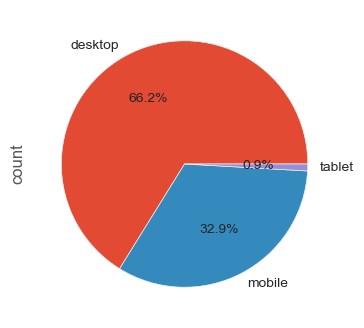

In [143]:
%matplotlib inline
import matplotlib.pyplot as plt


df3['deviceCategory'].value_counts().plot(kind='pie', figsize=(8.5, 4), autopct='%1.1f%%', subplots=True, legend=False)


### Platform

In [144]:
df3['platform'].value_counts()

platform
Windows      7077
Macintosh    3465
Android      3062
iOS          2376
Linux         226
Chrome OS      70
Name: count, dtype: int64

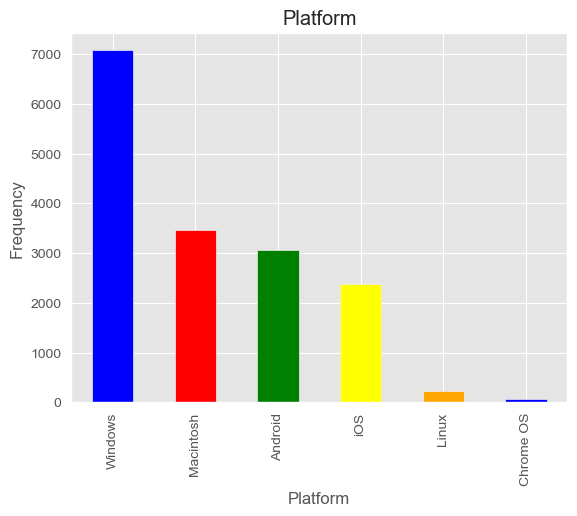

In [145]:
df3['platform'].value_counts().head(20).plot(kind='bar',title='Platform', color = ['blue','red','green','yellow','orange'])
plt.xlabel('Platform')
plt.ylabel('Frequency');

### dataSource

In [146]:
df3['dataSource'].value_counts()

dataSource
web    16276
Name: count, dtype: int64

### source

In [147]:
df3['source'].value_counts()

source
google                            5671
(direct)                          1692
share.hsforms.com                  418
bing                               183
meetup.com                         165
app.hubspot.com                    140
youtube.com                        135
meetings.hubspot.com                67
cio.com                             56
mail.google.com                     51
rss                                 42
linkedin.com                        40
reddit.com                          35
tagassistant.google.com             24
linktr.ee                           24
switchup.org                        19
careerkarma                         19
duckduckgo                          18
conted.ucalgary.ca                  17
hs_email                            16
yahoo                               16
dnserrorassist.att.net              12
statics.teams.cdn.office.net         9
localhost:8890                       9
l.facebook.com                       9
ca.search.yahoo.co

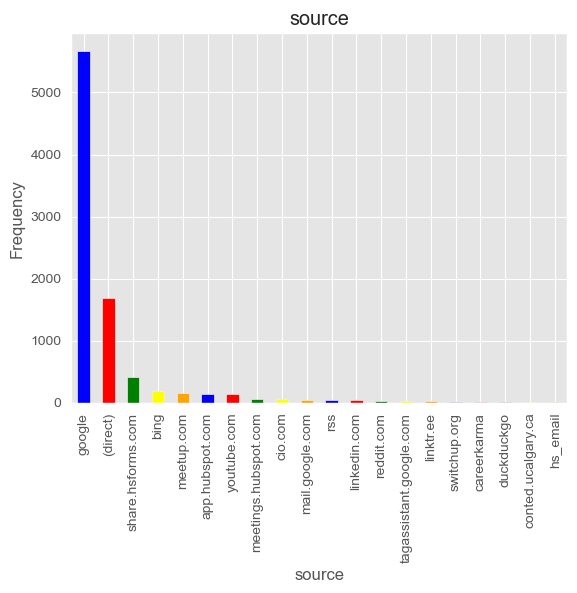

In [148]:
df3['source'].value_counts().head(20).plot(kind='bar',title='source', color = ['blue','red','green','yellow','orange'])
plt.xlabel('source')
plt.ylabel('Frequency');

### medium

In [149]:
df3['medium'].value_counts()

medium
cpc                  3071
organic              2821
(none)               1692
referral             1318
rss                    42
(not set)              18
email                  16
coursereportapply       2
events                  2
schoolpage              1
Name: count, dtype: int64

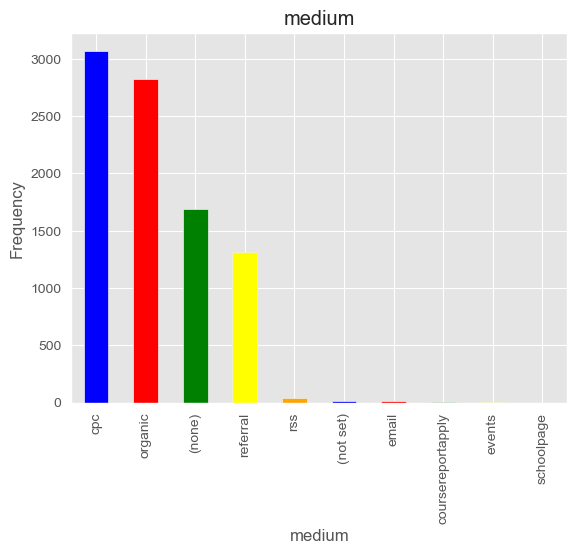

In [150]:
df3['medium'].value_counts().head(20).plot(kind='bar',title='medium', color = ['blue','red','green','yellow','orange'])
plt.xlabel('medium')
plt.ylabel('Frequency');

### channelGrouping

In [151]:
df3['channelGrouping'].value_counts()

channelGrouping
Paid Search       3001
Organic Search    2821
Direct            1692
Referral           927
Social             391
Display             70
(Other)             65
Email               16
Name: count, dtype: int64

array([<Axes: ylabel='count'>], dtype=object)

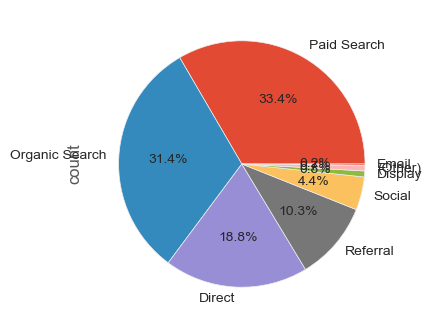

In [152]:
df3['channelGrouping'].value_counts().plot(kind='pie', figsize=(8.5, 4), autopct='%1.1f%%', subplots=True, legend=False)

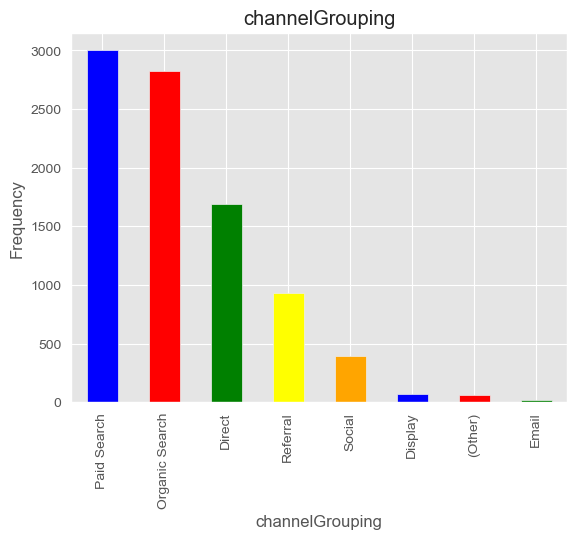

In [153]:
df3['channelGrouping'].value_counts().head(20).plot(kind='bar',title='channelGrouping', color = ['blue','red','green','yellow','orange'])
plt.xlabel('channelGrouping')
plt.ylabel('Frequency');

### campaign

In [154]:
df3['campaign'].value_counts()

campaign
(not set)                                                       5890
DS-FT-PerfMax-NA                                                 885
BI-TCPA-Search-WebsiteForm_Lead                                  289
DS-TCPA-PerfMax-WebsiteForm-Lead                                 262
DevOps-TCPA-Search-WebsiteForm-Lead                              227
MLE-TCPA-NA                                                      207
MLE-TCPA-Search-WebsiteForm-Lead                                 192
DS-FT-TCPA-East                                                  186
DevOps-TCPA-NA-East                                              181
DE-TCPA-NA                                                       159
DS_P-Max_Lead                                                     82
BI-TCPA-NA                                                        66
Website_Trafic&Reach_Display                                      42
DE-TCPA-Search-WebsiteForm-Lead                                   32
install-and-run-container

### keyword

In [155]:
df3['keyword'].value_counts()

keyword
(not set)                       4400
(not provided)                  2802
weclouddata                      241
we cloud data                     63
data engineer                     56
                                ... 
learn data engineering             1
ai ml platforms                    1
python engineer job                1
cloud engineer bootcamp free       1
ai and ml engineering              1
Name: count, Length: 274, dtype: int64

### hostname

In [156]:
df3['hostname'].value_counts()

hostname
weclouddata.com                                 8919
stg-weclouddata-staging.kinsta.cloud              29
staging-weclouddata-weclouddata.kinsta.cloud      26
cpanel.weclouddata.com                             9
Name: count, dtype: int64

### landingPagePath

In [157]:
df3['landingPagePath'].value_counts()

landingPagePath
/                                                       1414
/courses/online/data-science-bootcamp/                   783
/courses/online/devops-bootcamp/                         520
/courses/online/ml-engineering-bootcamp/                 504
/courses/online/data-engineering-bootcamp-part-time/     501
                                                        ... 
/?gtm_debug=1686182473856                                  1
/?gtm_debug=1686096280711                                  1
/?gtm_debug=1685369184473                                  1
/student_stories/nathan-ling/                              1
/404.html?page=/course-package/&from=                      1
Name: count, Length: 377, dtype: int64

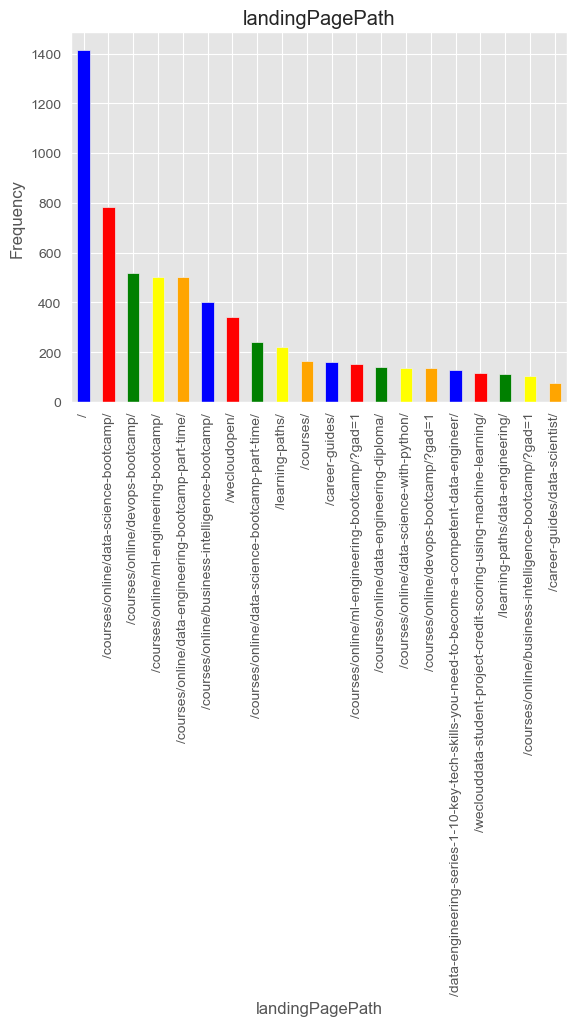

In [158]:
df3['landingPagePath'].value_counts().head(20).plot(kind='bar',title='landingPagePath', color = ['blue','red','green','yellow','orange'])
plt.xlabel('landingPagePath')
plt.ylabel('Frequency');

array([<Axes: ylabel='count'>], dtype=object)

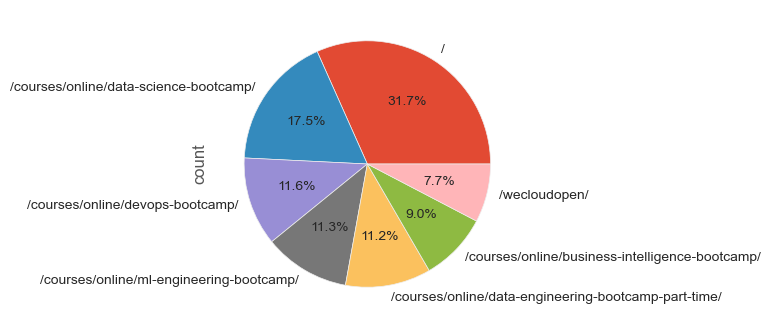

In [159]:
df3['landingPagePath'].value_counts().head(7).plot(kind='pie', figsize=(8.5, 4), autopct='%1.1f%%', subplots=True, legend=False)

### activityType

In [160]:
df3['activityType'].value_counts()

activityType
PAGEVIEW    8973
EVENT         10
Name: count, dtype: int64

### customDimension

In [161]:
df3['customDimension'].value_counts()

customDimension
[{'index': 1}]    8983
Name: count, dtype: int64

### pageview.pagePath

In [162]:
df3['pageview.pagePath'].value_counts()

pageview.pagePath
/                                                       1414
/courses/online/data-science-bootcamp/                   783
/courses/online/devops-bootcamp/                         520
/courses/online/ml-engineering-bootcamp/                 504
/courses/online/data-engineering-bootcamp-part-time/     501
                                                        ... 
/?gtm_debug=1686277674328                                  1
/?gtm_debug=1686182473856                                  1
/?gtm_debug=1686096280711                                  1
/?gtm_debug=1685369184473                                  1
/404.html?page=/course-package/&from=                      1
Name: count, Length: 376, dtype: int64

array([<Axes: ylabel='count'>], dtype=object)

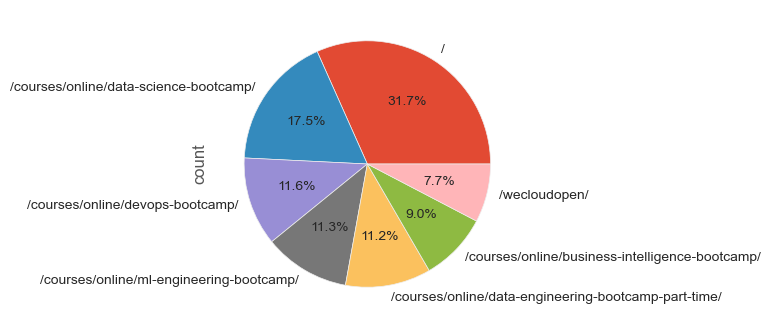

In [163]:
df3['pageview.pagePath'].value_counts().head(7).plot(kind='pie', figsize=(8.5, 4), autopct='%1.1f%%', subplots=True, legend=False)

### pageview.pageTitle

In [ ]:
df3['pageview.pageTitle'].value_counts()

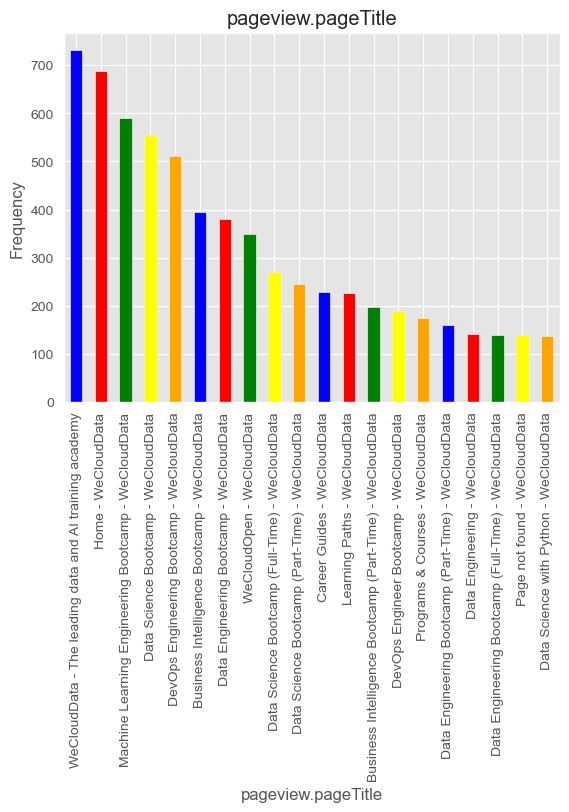

In [165]:
df3['pageview.pageTitle'].value_counts().head(20).plot(kind='bar',title='pageview.pageTitle', color = ['blue','red','green','yellow','orange'])
plt.xlabel('pageview.pageTitle')
plt.ylabel('Frequency');

### event.eventCategory

In [166]:
df3['event.eventCategory'].value_counts()

event.eventCategory
download         7
outbound-link    3
Name: count, dtype: int64

### event.eventAction

In [ ]:
df3['event.eventAction'].value_counts()

### event.eventLabel

In [168]:
df3['event.eventLabel'].value_counts()

event.eventLabel
Download                    6
Published May 19            1
Linkedin                    1
WeCareer                    1
Download Program Package    1
Name: count, dtype: int64

array([<Axes: ylabel='count'>], dtype=object)

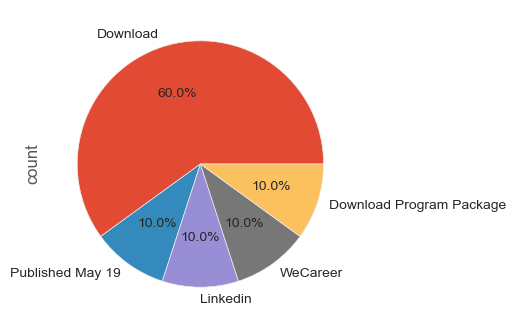

In [169]:
df3['event.eventLabel'].value_counts().plot(kind='pie', figsize=(8.5, 4), autopct='%1.1f%%', subplots=True, legend=False)

### event.eventCount

In [170]:
df3['event.eventCount'].value_counts()

event.eventCount
1    10
Name: count, dtype: int64